# Phase 2: Data Cleaning

## Overview
After exploring the dataset in Phase 1, I identified a critical data quality issue: **"fake zeros"** - values recorded as 0 that actually represent missing data.

### Why This Matters
In medical data, certain measurements cannot be zero for a living patient:
- Blood Pressure of 0 = clinically impossible
- BMI of 0 = invalid measurement
- Glucose of 0 = would indicate death

These zeros were likely entered when the measurement was unavailable, not because the actual value was zero.

### Our Approach
We will:
1. Identify which columns can legitimately have zeros
2. Replace impossible zeros with `NaN` (Not a Number) to mark them as missing
3. Analyze the impact of this cleaning
4. Decide on a strategy for handling the missing values

---

## Step 1: Understanding Which Columns Can Have Zeros

Based on the research paper ("Diagnosing Diabetes with Machine Learning Techniques") and medical knowledge:

| Column | Can Be Zero? | Reason |
|--------|--------------|--------|
| **Pregnancies** | ✅ Yes | Women can have zero pregnancies |
| **Glucose** | ❌ No | Blood glucose must be >0 for living patients |
| **BloodPressure** | ❌ No | Diastolic BP must be >0 for living patients |
| **SkinThickness** | ❌ No | All patients have measurable skin thickness |
| **Insulin** | ❌ No | Serum insulin must be >0 for living patients |
| **BMI** | ❌ No | Body mass index must be >0 |
| **DiabetesPedigreeFunction** | ⚠️ Maybe | Could theoretically be 0 with no family history |
| **Age** | ❌ No | All patients are 21+ years old |
| **Outcome** | ✅ Yes | 0 = no diabetes, 1 = diabetes |

### Conclusion
We'll clean zeros from: **Glucose, BloodPressure, SkinThickness, Insulin, and BMI**

---

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('diabetes.csv')

print("Starting data cleaning process...")
print(f"Original dataset shape: {df.shape}")

Starting data cleaning process...
Original dataset shape: (768, 9)


## Step 2: Analyze the Extent of the Problem

Before cleaning, let's quantify how many zeros exist in each column. This helps us understand:
- Which columns are most affected
- Whether the problem is severe enough to impact our analysis
- How much data we might lose if we remove rows with zeros

---

In [3]:
# Define columns that shouldn't have zeros
columns_to_check = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

print("\n=== ZERO VALUE ANALYSIS ===")
print(f"Total patients in dataset: {len(df)}\n")

# Create a summary dataframe for better visualization
zero_summary = []

for column in columns_to_check:
    zero_count = (df[column] == 0).sum()  # Count zeros in column
    zero_percentage = (zero_count / len(df)) * 100  # Calculate percentage
    
    zero_summary.append({
        'Column': column,
        'Zero Count': zero_count,
        'Percentage': f"{zero_percentage:.1f}%"
    })
    
    print(f"{column}:")
    print(f"  - {zero_count} zeros ({zero_percentage:.1f}% of data)")
    print()

# Convert to DataFrame for nice display
zero_df = pd.DataFrame(zero_summary)
print("\nSummary Table:")
print(zero_df.to_string(index=False))


=== ZERO VALUE ANALYSIS ===
Total patients in dataset: 768

Glucose:
  - 5 zeros (0.7% of data)

BloodPressure:
  - 35 zeros (4.6% of data)

SkinThickness:
  - 227 zeros (29.6% of data)

Insulin:
  - 374 zeros (48.7% of data)

BMI:
  - 11 zeros (1.4% of data)


Summary Table:
       Column  Zero Count Percentage
      Glucose           5       0.7%
BloodPressure          35       4.6%
SkinThickness         227      29.6%
      Insulin         374      48.7%
          BMI          11       1.4%


### 📊 Visualization: Zeros by Column

A bar chart makes it easy to see which columns have the most data quality issues.

---

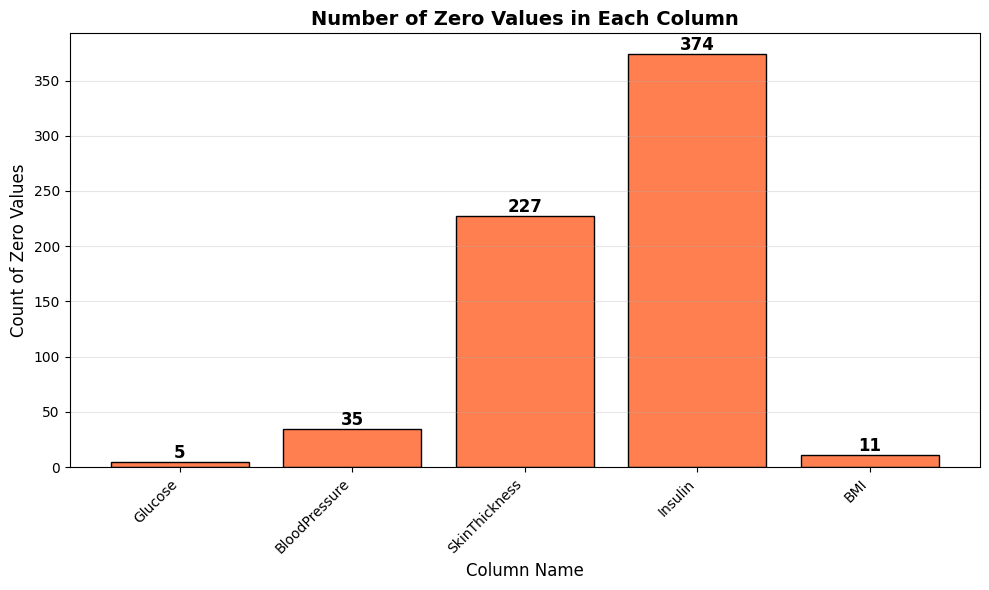


✅ Visualization complete!


In [4]:
# Create visualization of zero counts
plt.figure(figsize=(10, 6))

# Extract data for plotting
zero_counts = [item['Zero Count'] for item in zero_summary]
column_names = [item['Column'] for item in zero_summary]

# Create bar chart
bars = plt.bar(column_names, zero_counts, color='coral', edgecolor='black')

# Add count labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom', fontsize=12, fontweight='bold')

# Formatting
plt.title('Number of Zero Values in Each Column', fontsize=14, fontweight='bold')
plt.xlabel('Column Name', fontsize=12)
plt.ylabel('Count of Zero Values', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("\n✅ Visualization complete!")

### 💡 Key Findings

After analyzing the zeros, we can see:
- **Insulin** has the most zeros (often not measured in routine tests)
- **SkinThickness** also has many zeros
- **Glucose** and **BloodPressure** have fewer but still significant zeros
- **BMI** has the least zeros

**Decision:** We'll replace these zeros with `NaN` to properly represent missing data.

---

## Step 3: Create a Cleaned Dataset

### The `.copy()` Method
We use `.copy()` to create an independent copy of the original dataset. This is like making a backup before editing.

**Why?**
- Preserves the original data for comparison
- Prevents accidental changes to the original
- Allows us to try different cleaning strategies

**Caspio Analogy:** Like creating a test copy of your database before making schema changes.

### The `.replace()` Method
Replaces specific values with new values.

**Syntax:** `df.replace(old_value, new_value)`

---

In [6]:
# Create a copy of the original dataset
# This preserves df as our "original" for reference
df_clean = df.copy()

print("Created cleaned dataset copy: df_clean")
print(f"Shape: {df_clean.shape}")
print(f"\nVerifying it's a true copy: {df_clean is df}")  # Should be False

# Replace zeros with NaN in the specified columns
print("\nReplacing zeros with NaN in columns:")
for column in columns_to_check:
    # Replace 0 with np.nan (NumPy's representation of "Not a Number")
    df_clean[column] = df_clean[column].replace(0, np.nan)
    print(f"  ✓ {column}")

print("\n✅ Data cleaning complete!")

Created cleaned dataset copy: df_clean
Shape: (768, 9)

Verifying it's a true copy: False

Replacing zeros with NaN in columns:
  ✓ Glucose
  ✓ BloodPressure
  ✓ SkinThickness
  ✓ Insulin
  ✓ BMI

✅ Data cleaning complete!


## Step 4: Verify the Cleaning

Let's check that our cleaning worked by:
1. Counting zeros (should be 0 in cleaned columns)
2. Counting NaN values (should match the original zero counts)

---

In [7]:
print("=== VERIFICATION: BEFORE vs AFTER CLEANING ===\n")

for column in columns_to_check:
    # Count zeros in original
    original_zeros = (df[column] == 0).sum()
    
    # Count zeros in cleaned (should be 0)
    cleaned_zeros = (df_clean[column] == 0).sum()
    
    # Count NaN in cleaned (should match original zeros)
    cleaned_nans = df_clean[column].isnull().sum()
    
    print(f"{column}:")
    print(f"  Original zeros: {original_zeros}")
    print(f"  Cleaned zeros:  {cleaned_zeros} ← Should be 0")
    print(f"  Cleaned NaNs:   {cleaned_nans} ← Should match original zeros")
    print(f"  ✅ Success!" if cleaned_nans == original_zeros and cleaned_zeros == 0 else "  ⚠️ Check needed")
    print()

=== VERIFICATION: BEFORE vs AFTER CLEANING ===

Glucose:
  Original zeros: 5
  Cleaned zeros:  0 ← Should be 0
  Cleaned NaNs:   5 ← Should match original zeros
  ✅ Success!

BloodPressure:
  Original zeros: 35
  Cleaned zeros:  0 ← Should be 0
  Cleaned NaNs:   35 ← Should match original zeros
  ✅ Success!

SkinThickness:
  Original zeros: 227
  Cleaned zeros:  0 ← Should be 0
  Cleaned NaNs:   227 ← Should match original zeros
  ✅ Success!

Insulin:
  Original zeros: 374
  Cleaned zeros:  0 ← Should be 0
  Cleaned NaNs:   374 ← Should match original zeros
  ✅ Success!

BMI:
  Original zeros: 11
  Cleaned zeros:  0 ← Should be 0
  Cleaned NaNs:   11 ← Should match original zeros
  ✅ Success!



## Step 5: Compare Statistics - Before and After

Now let's see how replacing zeros with NaN affects our statistical summary. This is important because:
- The **mean** will change (zeros were pulling it down artificially)
- The **count** will show how many valid measurements we have
- The **min** values will be more realistic

---

In [8]:
print("=== ORIGINAL DATASET STATISTICS ===")
print(df[columns_to_check].describe())

print("\n\n=== CLEANED DATASET STATISTICS ===")
print(df_clean[columns_to_check].describe())

print("\n📝 Notice how the 'count' row shows fewer valid measurements in the cleaned dataset.")
print("   This is because NaN values are excluded from calculations by default.")

=== ORIGINAL DATASET STATISTICS ===
          Glucose  BloodPressure  SkinThickness     Insulin         BMI
count  768.000000     768.000000     768.000000  768.000000  768.000000
mean   120.894531      69.105469      20.536458   79.799479   31.992578
std     31.972618      19.355807      15.952218  115.244002    7.884160
min      0.000000       0.000000       0.000000    0.000000    0.000000
25%     99.000000      62.000000       0.000000    0.000000   27.300000
50%    117.000000      72.000000      23.000000   30.500000   32.000000
75%    140.250000      80.000000      32.000000  127.250000   36.600000
max    199.000000     122.000000      99.000000  846.000000   67.100000


=== CLEANED DATASET STATISTICS ===
          Glucose  BloodPressure  SkinThickness     Insulin         BMI
count  763.000000     733.000000     541.000000  394.000000  757.000000
mean   121.686763      72.405184      29.153420  155.548223   32.457464
std     30.535641      12.382158      10.476982  118.775855    

### 🔍 What Changed?

Let's highlight the key differences:

---

In [9]:
print("=== COMPARISON: MEAN VALUES ===")
print("\nColumn           | Original Mean | Cleaned Mean | Change")
print("-" * 60)

for column in columns_to_check:
    original_mean = df[column].mean()
    cleaned_mean = df_clean[column].mean()
    change = cleaned_mean - original_mean
    
    print(f"{column:16} | {original_mean:13.2f} | {cleaned_mean:12.2f} | {change:+6.2f}")

print("\n💡 The means increased because we removed the artificial zeros!")

=== COMPARISON: MEAN VALUES ===

Column           | Original Mean | Cleaned Mean | Change
------------------------------------------------------------
Glucose          |        120.89 |       121.69 |  +0.79
BloodPressure    |         69.11 |        72.41 |  +3.30
SkinThickness    |         20.54 |        29.15 |  +8.62
Insulin          |         79.80 |       155.55 | +75.75
BMI              |         31.99 |        32.46 |  +0.46

💡 The means increased because we removed the artificial zeros!


## Step 6: Analyze Missing Data Impact

Now that zeros are marked as NaN, let's see:
- How many **complete records** we have (no missing values)
- How many records have **at least one** missing value
- The distribution of missing values across records

---

In [10]:
# Count missing values per row
missing_per_row = df_clean[columns_to_check].isnull().sum(axis=1)

# Count complete records (no NaN in any checked column)
complete_records = (missing_per_row == 0).sum()
incomplete_records = len(df_clean) - complete_records

print("=== MISSING DATA IMPACT ===")
print(f"\nTotal records: {len(df_clean)}")
print(f"Complete records (no missing values): {complete_records} ({complete_records/len(df_clean)*100:.1f}%)")
print(f"Incomplete records (≥1 missing value): {incomplete_records} ({incomplete_records/len(df_clean)*100:.1f}%)")

# Show distribution of missing values
print("\n=== DISTRIBUTION OF MISSING VALUES ===")
print("\nRecords with X missing values:")
for i in range(6):  # 0 to 5 missing values
    count = (missing_per_row == i).sum()
    if count > 0:
        print(f"  {i} missing: {count} records ({count/len(df_clean)*100:.1f}%)")

=== MISSING DATA IMPACT ===

Total records: 768
Complete records (no missing values): 392 (51.0%)
Incomplete records (≥1 missing value): 376 (49.0%)

=== DISTRIBUTION OF MISSING VALUES ===

Records with X missing values:
  0 missing: 392 records (51.0%)
  1 missing: 142 records (18.5%)
  2 missing: 199 records (25.9%)
  3 missing: 28 records (3.6%)
  4 missing: 7 records (0.9%)


## 📊 Visualization: Missing Data Pattern

A heatmap shows us exactly where the missing data is located.

---

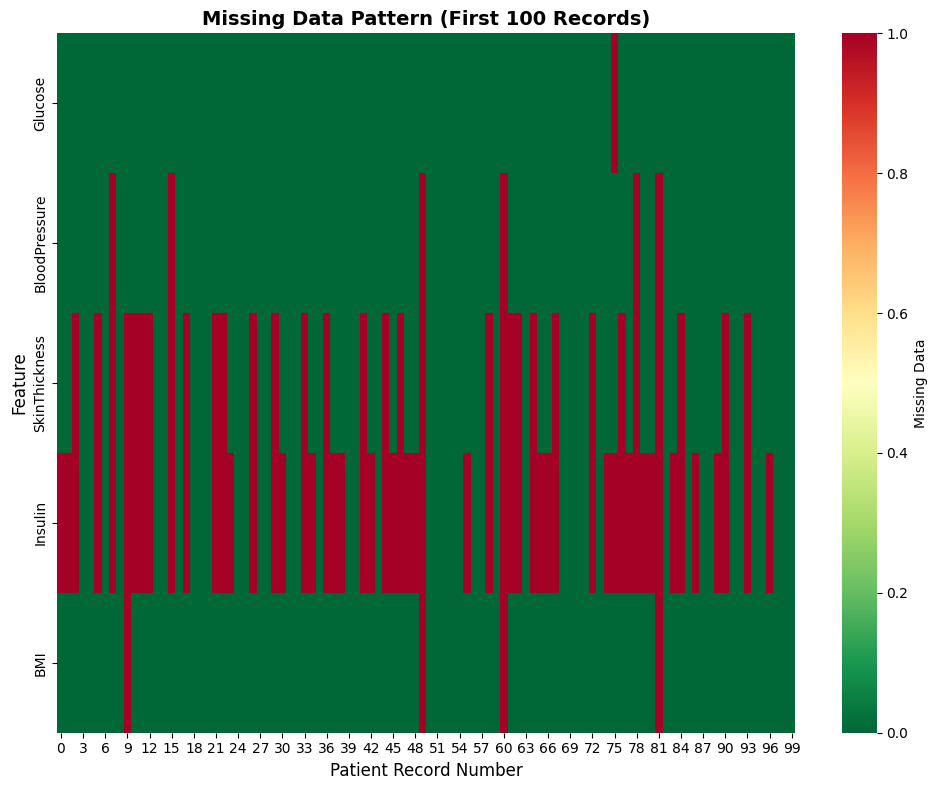


🎨 In the heatmap:
   - Dark red/brown = Missing data (NaN)
   - Light green = Data present


In [13]:
import seaborn as sns

# Create a boolean mask: True where data is missing
missing_mask = df_clean[columns_to_check].isnull()

# Plot first 100 rows to see the pattern
plt.figure(figsize=(10, 8))
sns.heatmap(missing_mask.head(100).T,  # Transpose for better view
            cmap='RdYlGn_r',  # Red = missing, Green = present
            cbar_kws={'label': 'Missing Data'},
            yticklabels=columns_to_check)

plt.title('Missing Data Pattern (First 100 Records)', fontsize=14, fontweight='bold')
plt.xlabel('Patient Record Number', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()

print("\n🎨 In the heatmap:")
print("   - Dark red/brown = Missing data (NaN)")
print("   - Light green = Data present")

## Step 7: Save Both Datasets

We'll keep both versions:
- **df** - Original with zeros (for reference)
- **df_clean** - Cleaned with NaN values (for analysis)

**Optional:** Export to CSV files for backup.

---

In [14]:
# Optional: Save cleaned dataset to CSV
df_clean.to_csv('diabetes_cleaned.csv', index=False)
print("✅ Cleaned dataset saved as 'diabetes_cleaned.csv'")

print("\n=== AVAILABLE DATASETS ===")
print(f"df        : Original dataset with zeros ({df.shape})")
print(f"df_clean  : Cleaned dataset with NaN ({df_clean.shape})")
print("\n✅ Both datasets are ready for the next phase!")

✅ Cleaned dataset saved as 'diabetes_cleaned.csv'

=== AVAILABLE DATASETS ===
df        : Original dataset with zeros ((768, 9))
df_clean  : Cleaned dataset with NaN ((768, 9))

✅ Both datasets are ready for the next phase!


---

## 📋 Summary: What We Accomplished

### ✅ Phase 2 Complete!

1. **Identified the problem**: Found "fake zeros" in medical measurements
2. **Quantified the issue**: Counted zeros in each column
3. **Cleaned the data**: Replaced impossible zeros with NaN
4. **Verified our work**: Confirmed cleaning was successful
5. **Analyzed the impact**: Understood how much data is affected

### 🎯 Next Steps (Phase 3: Handling Missing Data)

Now we need to decide what to do with the NaN values. Options include:

1. **Option A: Drop rows with missing values**
   - Pro: Simple, no imputation needed
   - Con: Might lose too much data

2. **Option B: Fill with median/mean values**
   - Pro: Keeps all records
   - Con: Introduces artificial data

3. **Option C: Keep two datasets**
   - Pro: Can compare results
   - Con: More complexity


### 📚 Key Python Concepts Learned

- `.copy()` - Create independent dataset copies
- `.replace()` - Replace values in a DataFrame
- `np.nan` - NumPy's representation of missing data
- `.isnull()` - Check for missing values
- `.sum()` with `axis=1` - Count across rows
- Boolean indexing - Filter data based on conditions

---

## 💬 Discussion Questions for project

1. How much missing data is acceptable for our analysis?
2. Should we drop records with missing Insulin values (since there are so many)?
3. Is it better to fill missing values or remove those records?
4. Should we create separate analyses for "complete records only" vs "all records"?

---